### Verification that Tractor is running smoothly


dlnp 4513.523076454851
dlnp 463.4199788197744
dlnp 0.0012550546867373669
dlnp 2.5142746835626895e-06


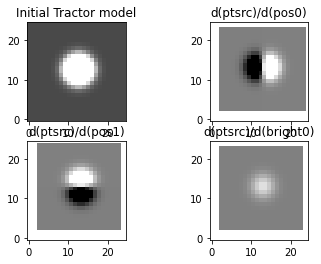

In [4]:
import numpy as np
import pylab as plt
from tractor import *

# Size of image, centroid and flux of source
W,H = 25,25
cx,cy = 12.8, 14.3
flux = 12.
# PSF size
psfsigma = 2.
# Per-pixel image noise
noisesigma = 0.01
# Create synthetic Gaussian star image
G = np.exp(((np.arange(W)-cx)[np.newaxis,:]**2 +
            (np.arange(H)-cy)[:,np.newaxis]**2)/(-2.*psfsigma**2))
trueimage = flux * G/G.sum()
image = trueimage + noisesigma * np.random.normal(size=trueimage.shape)

# Create Tractor Image
tim = Image(data=image, invvar=np.ones_like(image) / (noisesigma**2),
            psf=NCircularGaussianPSF([psfsigma], [1.]),
            wcs=NullWCS(), photocal=NullPhotoCal(),
            sky=ConstantSky(0.))

# Create Tractor source with approximate position and flux
src = PointSource(PixPos(W/2., H/2.), Flux(10.))

# Create Tractor object itself
tractor = Tractor([tim], [src])

# Render the model image
mod0 = tractor.getModelImage(0)
chi0 = tractor.getChiImage(0)

# Plots
ima = dict(interpolation='nearest', origin='lower', cmap='gray',
           vmin=-2*noisesigma, vmax=5*noisesigma)
imchi = dict(interpolation='nearest', origin='lower', cmap='gray',
             vmin=-5, vmax=5)
plt.clf()
plt.subplot(2,2,1)
plt.imshow(trueimage, **ima)
plt.title('True image')
plt.subplot(2,2,2)
plt.imshow(image, **ima)
plt.title('Image')
plt.subplot(2,2,3)
plt.imshow(mod0, **ima)
plt.title('Tractor model')
plt.subplot(2,2,4)
plt.imshow(chi0, **imchi)
plt.title('Chi')

# Freeze all image calibration params -- just fit source params
tractor.freezeParam('images')

# Save derivatives for later plotting...
derivs = tractor.getDerivs()

# Take several linearized least squares steps
for i in range(10):
    dlnp,X,alpha = tractor.optimize()
    print ('dlnp', dlnp)
    if dlnp < 1e-3:
        break

# Get the fit model and residual images for plotting
mod = tractor.getModelImage(0)
chi = tractor.getChiImage(0)
# Plots
plt.clf()
plt.subplot(2,2,1)
plt.imshow(trueimage, **ima)
plt.title('True image')
plt.subplot(2,2,2)
plt.imshow(image, **ima)
plt.title('Image')
plt.subplot(2,2,3)
plt.imshow(mod, **ima)
plt.title('Tractor model')
plt.subplot(2,2,4)
plt.imshow(chi, **imchi)
plt.title('Chi')


# Plot the derivatives we saved earlier
def showpatch(patch, ima):
    im = patch.patch
    h,w = im.shape
    ext = [patch.x0,patch.x0+w, patch.y0,patch.y0+h]
    plt.imshow(im, extent=ext, **ima)
    plt.title(patch.name)
imderiv = dict(interpolation='nearest', origin='lower', cmap='gray',
               vmin=-0.05, vmax=0.05)
plt.clf()
plt.subplot(2,2,1)
plt.imshow(mod0, **ima)
ax = plt.axis()
plt.title('Initial Tractor model')
for i in range(3):
    plt.subplot(2,2,2+i)
    showpatch(derivs[i][0][0], imderiv)
    plt.axis(ax)
